# Final Project - Classify Trade Request Emails
## NLP with Deep Learning (LSTMs, GRUs)

By: Austin Jenkins

Class: CSCA 5642 - Introduction to Deep Learning

Github Repository: https://github.com/ajenkins198621/csca-5642-final-project

# I. Introduction

### Background

For these assignments, I like to try to use examples that are relevant to my work.  I have a software application that helps I have a software application that helps car dealerships trade vehicles.  I would like to use some of the deep learning models we have learned in this course to try to solve some images we've had.

Part of this application requires communication from our dealers.  So, dealers who use our software can reach out (via email messages) to other dealers to request a trade, we call these "Outbound Requests".  Or, other dealerships can reach out to the dealerships who use our software and request a trade, we call these "Inbound Requests".  A "trade" typically contains one or more vehicles that the dealership wants.  Then, the other dealer can respond that they are willing to trade or not.  If they do want to trade, they will often provide one or more vehicles that the they'd be willing to trade.

I would like to build a model that can classify the message that comes in.  Below are the general classifications of messages that I would like to classify:

1. <strong>Inbound Request to Trade Vehicle</strong>
    - This occurs when another dealership reaches out to one of our dealerships to request a trade.
2. <strong>Yes response, to outbound request</strong>
    - If a dealership responds to one of our outbound requests with a "Yes", then we want to classify this as such.  However, people often don't just respond with a "Yes", so we need to use Machine Learning to classify whether it is a "Yes" or not.
3. <strong>No response, to outbound request</strong>
    - If a dealership responds to one of our outbound requests with a "No", then we want to classify this as such.  Similar to a yes response, people don't respond with a binary yes/no so we need to use Machine Learning to classify whether it is a "No" or not.
4. <strong>General Correspondence</strong>
    - This is a general message that doesn't fit into any of the other categories.
5. <strong>Spam</strong>
    - We do often also get spam messages, so we want to classify these as well.


# II. The Data and EDA

### Import Dependencies

In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_text
from tqdm import tqdm

from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.layers import TextVectorization, Embedding, SimpleRNN, Dense, Dropout, BatchNormalization, LSTM, GRU, SpatialDropout1D, Bidirectional
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")


### Set Default Plot Styles

In [2]:
plt.style.use('dark_background')

color_inbound = '#27213C'
color_yes = '#5A352A'
color_no = '#A33B20'
color_general = '#A47963'
color_spam = '#A6A57A'

### Data Source

This data was stored in a SQL database.  I used a SQL query to extract the data and then saved it to a CSV file.  I removed some of the columns that I didn't think would be useful for this analysis.  The export has close to 300,000 rows of data.

### Load the Initial Data

Ok, so first I need to load the initial data and take a look at it.

In [3]:
initial_data_pd = pd.read_csv('inbound_emails_export.csv')

Note, there is some potentially sensitive information in this data, so I will be using "***" for those fields.

In [4]:
def get_preview_version_of_data_frame(df):
    df = df.copy()
    if "from" in df.columns:
        df["from"] = "***"
    if "full_from" in df.columns:
        df["full_from"] = "***"
    if "to" in df.columns:
        df["to"] = "***"
    if "cc" in df.columns:
        df["cc"] = "***"
    return df


In [5]:
get_preview_version_of_data_frame(initial_data_pd).head()

,id,contact_id,from,full_from,to,cc,subject,message_id,reply_message_id,message,parse_description,created_at,updated_at
0,2,0,***,***,***,***,Re: 2019 Encore Swap Request from BUICK GMC OF...,CANk33agvLzYtHbTBbCYYPkAGf8EMpeEo14PuT_iDyUV5O...,1dce7e6ed220f85abf1a58814b01a6ae@swaptimal.com,Sure thing,NaN,6/11/19 18:16,6/11/19 18:16
1,3,0,***,***,***,***,Re: 19 Acadia Denali Swap Request from BUICK G...,CANk33aiMSy2vG+PT+F-Ma9ga2SSA0A9MpJqjU0OKCbs=3...,a1fadd3e9c7756494311bb6bc736d5f1@swaptimal.com,Yes it is available. I would like this Terrain...,NaN,6/11/19 20:29,6/11/19 20:29
2,4,0,***,***,***,***,RE: 2019 Encore Swap Request from BUICK GMC OF...,BN6PR17MB163576F2B7D59AB4D1EE44758AEC0@BN6PR17...,e898df52b3cca761c2931be7c087b723@swaptimal.com,Will check in a moment sorry for the delay!\r\...,NaN,6/12/19 17:09,6/12/19 17:09
3,5,0,***,***,***,***,Re: Tes Swap Request from FINLEY MOTORS INC.,CAGzE-5VBb0oN52QMrs033JqrvZZ1aTTQan-JRYOYX75VH...,037ffbc8da62c95fe60c4106e510d83f@swaptimal.com,Hey here’s another message,NaN,6/12/19 18:46,6/12/19 18:46
4,6,0,***,***,***,***,RE: Tes Swap Request from FINLEY MOTORS INC.,CAGzE-5WCo3n1gDXoK96TAKxreo8z-cTEe3ZZDCyox+Acz...,0829f3bd4ea8366908a48c027bad4560@swaptimal.com,Love it!,NaN,6/12/19 18:49,6/12/19 18:49


In [6]:
get_preview_version_of_data_frame(initial_data_pd).tail()

,id,contact_id,from,full_from,to,cc,subject,message_id,reply_message_id,message,parse_description,created_at,updated_at
296481,296491,0,***,***,***,***,Trade Inquiry for VIN - KL47LAEP8SB084894,IA1PR14MB575494B629B06F3CEA5B999DA8F42@IA1PR14...,NaN,IS THIS AVAILABLE?\n\nVehicle Information: \n\...,Inbound Request,2/4/25 0:24,2/4/25 0:24
296482,296492,0,***,***,***,***,RE: [EXTERNAL] RE: Swap Request from MEDINA AU...,SJ0P222MB018524C8FDEACA9F201CF7D7A2F42@SJ0P222...,249e784044b30300e415f6f5a8d0e965@mg.swaptimal.com,NO. ITS SOLD.\n\n \n\nJamie Widner\n\nSales Ma...,Message ID match,2/4/25 0:45,2/4/25 0:45
296483,296493,0,***,***,***,***,DEALER TRADE SU107868,-y3d06YfSLix2wnDgR7umw@geopod-ismtpd-8,NaN,"Good evening, Brad\n\nJust checking to see if ...",Inbound Request,2/4/25 0:51,2/4/25 0:51
296484,296494,0,***,***,***,***,Re: [External] Swap Request from JUNCTION BUIC...,8E726CCF-4E95-4A88-8975-8DB8430E109E@smailauto...,8a7287268308f2b9950efa5c37ba3170@mg.swaptimal.com,Matt have meeting then will get back to you so...,Message ID match,2/4/25 11:03,2/4/25 11:03
296485,296495,0,***,***,***,***,"Re: Swap Request from JOE LUNGHAMER CHEVROLET,...",BN7PR07MB5203ACB04F7639FE7F9DD060A6F42@BN7PR07...,a334ac029155d9408bd728758265e14e@mg.swaptimal.com,"Joe,\n\nWill always try to help you guys out.\...",Message ID match,2/4/25 11:31,2/4/25 11:31


Ok, great.  So I can immediately see some columns that I don't think we need.  These include:

- id
- contact_id
- full_from
- cc
- message_id
- reply_message_id
- parse_description
- created_at
- updated_at

In [7]:
initial_data_pd.drop(
    columns=[
        'id',
        'contact_id',
        'full_from',
        'cc',
        'message_id',
        'reply_message_id',
        'parse_description',
        'created_at',
        'updated_at'
    ], inplace=True)

get_preview_version_of_data_frame(initial_data_pd).head()

,from,to,subject,message
0,***,***,Re: 2019 Encore Swap Request from BUICK GMC OF...,Sure thing
1,***,***,Re: 19 Acadia Denali Swap Request from BUICK G...,Yes it is available. I would like this Terrain...
2,***,***,RE: 2019 Encore Swap Request from BUICK GMC OF...,Will check in a moment sorry for the delay!\r\...
3,***,***,Re: Tes Swap Request from FINLEY MOTORS INC.,Hey here’s another message
4,***,***,RE: Tes Swap Request from FINLEY MOTORS INC.,Love it!


Perfect.  So this will leave us with the 4 columns needed for this analysis. They should all be strings, but let's take a look at the data types.

In [8]:
initial_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296486 entries, 0 to 296485
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   from     296480 non-null  object
 1   to       293897 non-null  object
 2   subject  295507 non-null  object
 3   message  296141 non-null  object
dtypes: object(4)
memory usage: 9.0+ MB


Perfect, we can see there are a total of 296,486 rows.  However, there appears to be some null values in each of the columns.  I'll go ahead and clean those up now.

In [9]:
initial_data_pd.dropna(inplace=True)

Great, now we have 292,679 rows and there are no null values in any of the columns.

I also happen to know that the messages column can contain some line breaks, so I'll go ahead and remove those now.

In [10]:
initial_data_pd["message"] = initial_data_pd["message"].str.replace(r"[\n\r]", " ", regex=True)

Ok, so now I need to save this initial_data_pd as a CSV file so I can do some manually classification.

In [11]:
initial_data_pd.to_csv("inbound_emails_export_formatted.csv", index=False)

### Adding Labels to the Data

I have manually classified a sample of the data and saved this as a file called data.csv.  The classifications are as follows:
0. Inbound Request to Trade Vehicle
1. Yes response, to outbound request
2. No response, to outbound request
3. General Correspondence
4. Spam

In [12]:
all_data_df = pd.read_csv("data.csv")

get_preview_version_of_data_frame(all_data_df).head()
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       471 non-null    int64 
 1   from     471 non-null    object
 2   to       471 non-null    object
 3   subject  471 non-null    object
 4   message  471 non-null    object
 5   label    471 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 22.2+ KB


### Data Histograms

Now, I'll take a look at the histograms of the data to see the distribution of the data.  I'll take a look at a bar and pie chart of the target variable to see the distribution of the target variable.

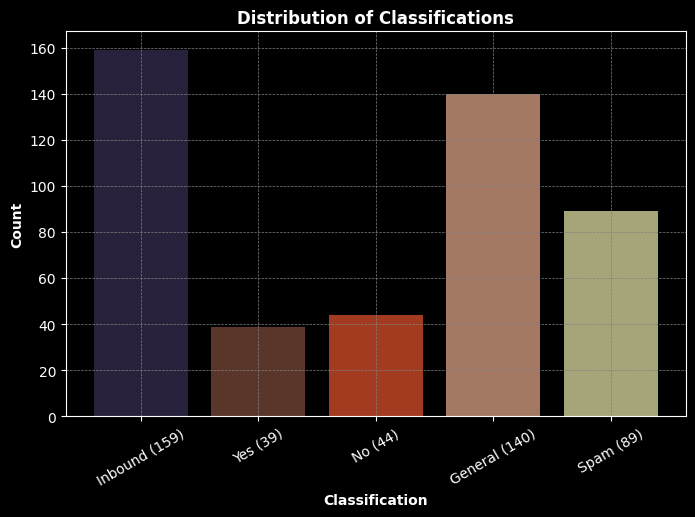

In [13]:
counts = all_data_df['label'].value_counts()

colors = [color_inbound, color_yes, color_no, color_general, color_spam]
labels = [f"Inbound ({counts[1]})", f"Yes ({counts[2]})", f"No ({counts[3]})", f"General ({counts[4]})", f"Spam ({counts[5]})"]
values = [counts[1], counts[2], counts[3], counts[4], counts[5]]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=colors)
plt.title("Distribution of Classifications", fontweight='bold')
plt.xlabel("Classification", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.grid(True, linewidth=0.5, color='gray', linestyle='--')
plt.xticks(rotation=30)

plt.show()


It looks like we have a decent distribution of messages.  It isn't a surprise to me that there are the most inbound, general and spams, since those messages are the most common.

Next, I'll take a look at a bar graph of the data.

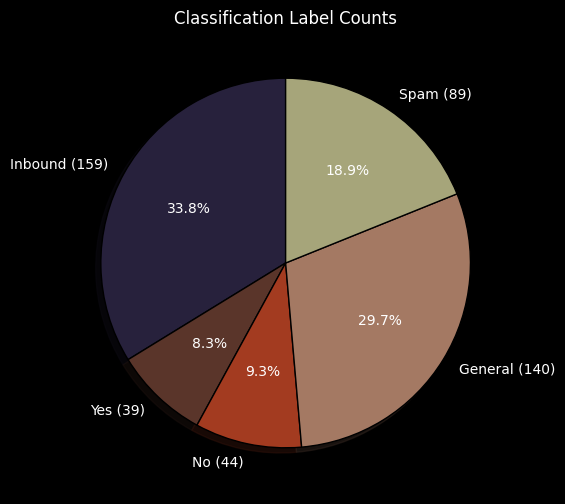

In [14]:
plt.figure(figsize=(6, 6))

plt.pie(values,
        labels=labels,
        colors=colors,
        shadow=True,
        startangle=90,
        autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})

plt.title("Classification Label Counts")
plt.show()

### Word Clouds

Next, I think it would be useful to look at a wordcloud of the *messages* for each of the classifications.

In [15]:
def draw_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(6, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontweight='bold')
    plt.show()

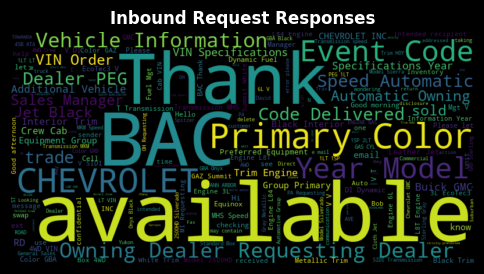

In [16]:
inbound_text = "".join(all_data_df[all_data_df['label'] == 1]['message'])
draw_wordcloud(inbound_text, "Inbound Request Responses")

Seeing words like "available" being predominant in this word cloud is a good indicator, because it is common for people to ask "is this vehicle still available?".

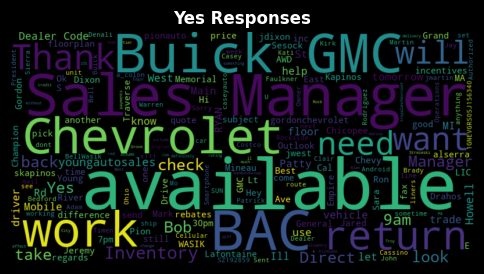

In [17]:
yes_text = "".join(all_data_df[all_data_df['label'] == 2]['message'])
draw_wordcloud(yes_text, "Yes Responses")

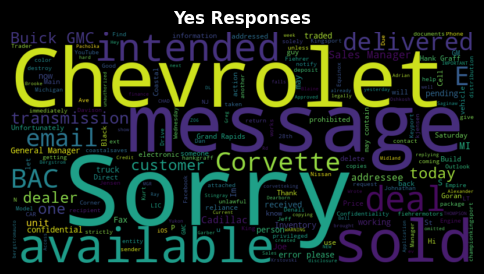

In [18]:
no_text = "".join(all_data_df[all_data_df['label'] == 3]['message'])
draw_wordcloud(no_text, "Yes Responses")

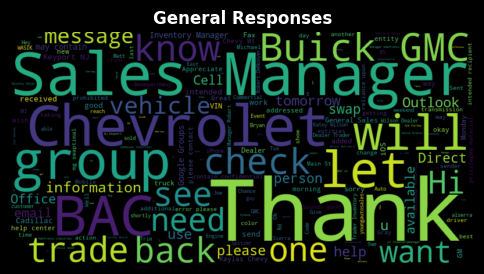

In [19]:
general_text = "".join(all_data_df[all_data_df['label'] == 4]['message'])
draw_wordcloud(general_text, "General Responses")

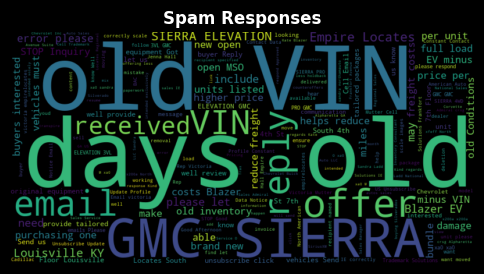

In [20]:
spam_text = "".join(all_data_df[all_data_df['label'] == 5]['message'])
draw_wordcloud(spam_text, "Spam Responses")

# III. The Models

### NLP Preprocessing & Word Embeddings

In [21]:
all_messages = [message for message in all_data_df['message']]

# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_messages)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(all_messages)

# Get the word index
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4497 unique tokens.


Next, I'll split my data into training and testing data.

In [22]:
# Split Data BEFORE Padding
X_train, X_test, y_train, y_test = train_test_split(sequences, all_data_df['label'], test_size=0.2, random_state=42)

Next I'll pad the sequences so that they are all the same length.

In [23]:
# Pad sequences
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

# Get labels
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Define MAX_SEQUENCE_LENGTH from training set
MAX_SEQUENCE_LENGTH = X_train.shape[1]
print('MAX_SEQUENCE_LENGTH:', MAX_SEQUENCE_LENGTH)


Found 4497 unique tokens.
MAX_SEQUENCE_LENGTH: 714


Next, I'll implement GloVe word embeddings to convert the text data into numerical data.  I downloaded the GloVe word embeddings from the Stanford NLP group: https://nlp.stanford.edu/projects/glove/.

In [24]:
embeddings_index = {}
with open('./glove.6b/glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Number of words in library:  %s' % len(embeddings_index))


400000it [00:07, 56533.42it/s]

Number of words in library:  400000


Next, we'll create the embedding matrix.

In [25]:
EMBEDDING_DIM = 200

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print("Matrix Size", embedding_matrix.shape)

100%|██████████| 4497/4497 [00:00<00:00, 166357.55it/s]

Matrix Size (4498, 200)


Next, I'll define the embedding layer

In [26]:
embedding = Embedding(
    len(word_index) + 1,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (4498, 200)


There's one more step I need to take to prepare my data.  My categorizations were 1-5, but I need 0-4.  So I'll subtract 1 from each of the categorizations.

In [27]:
y_train = y_train - 1
y_test = y_test - 1

### LSTM Model - Version 1

<strong>Architecture</strong>
1. Input Layer - Padded sequence of tokenized words
2. Embedding Layer - GloVe word embeddings
3. LSTM Layer - Bidirectional LSTM with 128 units
4. Fully Connected Layers
    - Dense Layer with 128 units and ReLU activation - to extract features
    - Batch Normalization - normalize the activations to stabilize the learning process
    - Dropout - to prevent overfitting
5. Output Layer - Dense Layer with 5 units and Softmax activation - to classify the input into one of the 5 classes
6. Model Compilation
    - Loss Function: Sparse Categorical Crossentropy
    - Optimizer: Adam
    - Metrics: Accuracy

<strong>Hyperparameters</strong>
- spatial_dropout - 0.3 - Randomly drops input units in the embedding layer to prevent overfitting.
- dropout - 0.3 - Drops random neurons in LSTM and Dense layers to reduce overfitting.
- recurrent_dropout - 0.3 - Applies dropout inside the LSTM to prevent overfitting on sequences.
- lstm_units - 128 - The number of LSTM neurons. Higher = more learning capacity but slower training.
- dense_units - 64 - Fully connected layer neurons, extracts meaningful features before classification.
- learning_rate - 0.0001
- epochs - 50 - Number of times the model will see the entire dataset.

<strong>Optimizer</strong>
- Adam
- Learning Rate - 0.0001 - Controls step size in gradient updates. Lower for fine-tuning.

In [28]:
def create_lstm(embedding_layer, spatial_dropout, lstm_units, dropout, recurrent_dropout, dense_units, learning_rate):

    # 1. Input Layer
    nlp_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='nlp_input')
    
    # 2. Embedding Layer (Pre-trained GloVe)
    emb = embedding_layer(nlp_input)  
    emb = SpatialDropout1D(spatial_dropout)(emb)

    # 3. LSTM Layer
    lstm_out = Bidirectional(LSTM(units=lstm_units, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False))(emb)

    # 4. Fully connected layers
    x = Dense(dense_units, activation="relu")(lstm_out)
    x = BatchNormalization()(x) 
    x = Dropout(dropout)(x)  

    # 5. Output layer (5-class classification -> Softmax)
    preds = Dense(5, activation="softmax")(x)  

    # 6. Compile the model
    model = Model(inputs=nlp_input, outputs=preds)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model


In [29]:
# Create the LSTM model
lstm_model = create_lstm(
    embedding,
    spatial_dropout=0.3,
    lstm_units=128,
    dropout=0.3,
    recurrent_dropout=0.3,
    dense_units=64,
    learning_rate=0.0001
)

# Display model summary
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)          │ (None, 714)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 714, 200)       │       899,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 714, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,525 (4.78 MB)

 Trainable params: 353,797 (1.35 MB)

 Non-trainable params: 899,728 (3.43 MB)

Next, I'll add early stopping to my model to prevent overfitting and reduce training time.

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

Great, now it's time to train the model!  

In [31]:
history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 962ms/step - accuracy: 0.1865 - loss: 2.2736 - val_accuracy: 0.2211 - val_loss: 1.6311
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 876ms/step - accuracy: 0.2652 - loss: 2.0686 - val_accuracy: 0.2316 - val_loss: 1.6179
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 901ms/step - accuracy: 0.2814 - loss: 1.9127 - val_accuracy: 0.2632 - val_loss: 1.6062
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 928ms/step - accuracy: 0.2888 - loss: 1.8509 - val_accuracy: 0.2526 - val_loss: 1.5946
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 870ms/step - accuracy: 0.3324 - loss: 1.7557 - val_accuracy: 0.2632 - val_loss: 1.5806
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 864ms/step - accuracy: 0.3288 - loss: 1.6918 - val_accuracy: 0.3263 - val_loss: 1.5658
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 898ms/step - accuracy: 0.3343 - loss: 1.6896 - val_accuracy: 0.3684 - val_loss: 1.5514
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4138 - loss: 1.5753 - val_accurac

Alright, let's take a look at the results in a plot.  First, I'll go ahead and create a shared function that we can use for other models.

In [32]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['accuracy'], label="Train Accuracy")
    ax[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax[0].set_title("Model Accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()

    ax[1].plot(history.history['loss'], label="Train Loss")
    ax[1].plot(history.history['val_loss'], label="Validation Loss")
    ax[1].set_title("Model Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()

    plt.show()


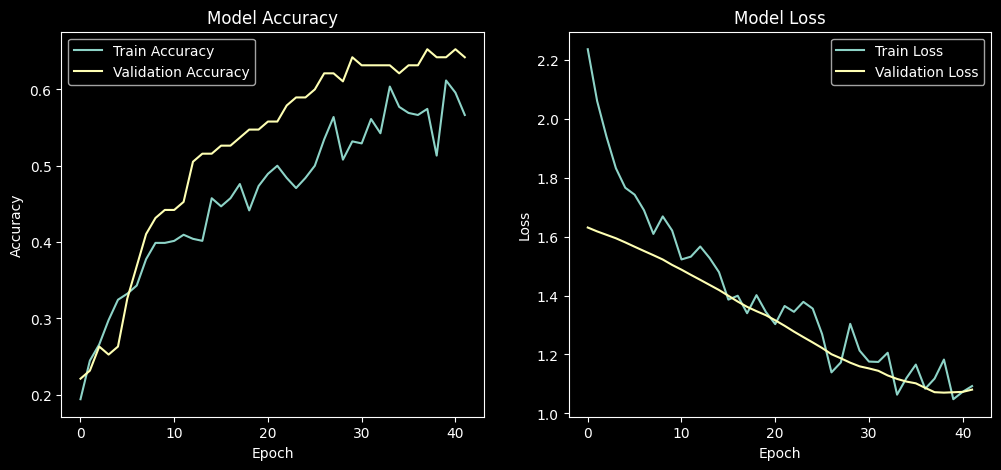

In [33]:
plot_learning_curves(history)

In [34]:
# TODO ADD ANALYSIS OF GRAPHS AFTER I'VE ADDED ADDITIONAL DATA TO THE MODEL

Now, I want to predict the test data and see how well the model did.  I'll take a look at the classification report and confusion matrix.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step


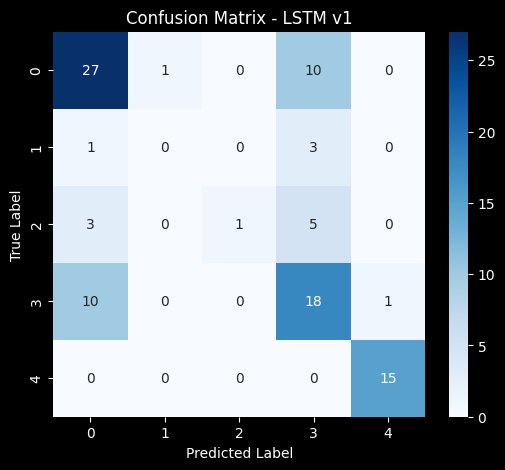

Classification Report:
 {'0': {'precision': 0.6585365853658537, 'recall': 0.7105263157894737, 'f1-score': 0.6835443037974683, 'support': 38.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '2': {'precision': 1.0, 'recall': 0.1111111111111111, 'f1-score': 0.2, 'support': 9.0}, '3': {'precision': 0.5, 'recall': 0.6206896551724138, 'f1-score': 0.5538461538461539, 'support': 29.0}, '4': {'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871, 'support': 15.0}, 'accuracy': 0.6421052631578947, 'macro avg': {'precision': 0.6192073170731708, 'recall': 0.48846541641459973, 'f1-score': 0.48102647862549863, 'support': 95.0}, 'weighted avg': {'precision': 0.6588093709884468, 'recall': 0.6421052631578947, 'f1-score': 0.6142352740852666, 'support': 95.0}}


In [35]:
y_pred = lstm_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM v1")
plt.show()

report = classification_report(y_test, y_pred_classes, output_dict=True)

In [36]:
# TODO ADD ANALYSIS OF CLASSIFICATION REPORT AND CONFUSION MATRIX AFTER I'VE ADDED ADDITIONAL DATA TO THE MODEL

Great, now I'll store the results in a dataframe so we can compare the results of the different models.

In [37]:
model_results = []

def add_results_to_overall_report(report, title):
    accuracy_per_class = {f'Class {int(k)}': v['recall'] for k, v in report.items() if k.isdigit()}
    accuracy_per_class['Model'] = title
    model_results.append(accuracy_per_class)

add_results_to_overall_report(report, "LSTM v1")

My primary concern with this model is that it is doing a poor job of classifying the "Yes" and "No" responses.  I know that these have the fewest responses of all messages, so in the next version of the model, I am going to try to balance the classes.  I will also tweak some of the hyperparameters.

### LSTM Model - Version 2 - Oversampling

As we saw in the first model, the "Yes" and "No" responses were not classified well.  I want to try to fix that and to try to improve the performance of the LSTM model overall.  I will try to balance the classes and tweak some of the hyperparameters.

<strong>Key Changes in LSTM Version 2</strong>
1. Oversample underrepresented labels - I will use the class weights to balance the classes.
2. Increase the Dropout Hyperparameter from 0.3 to 0.5 to reduce overfitting
3. Learning Rate - I will decrease the learning rate from 0.0001 to 0.00001 to fine-tune the model.
4. Remove early stopping - when I was training the model, I noticed that the model was not overfitting, so I will remove the early stopping callback.
5. Decrease the number of epochs from 50 to 20 to reduce training time.

First off, I'll try to balance the classes by using the class weights.

In [38]:
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

Let's visualize the label distributions before and after applying the class weights.

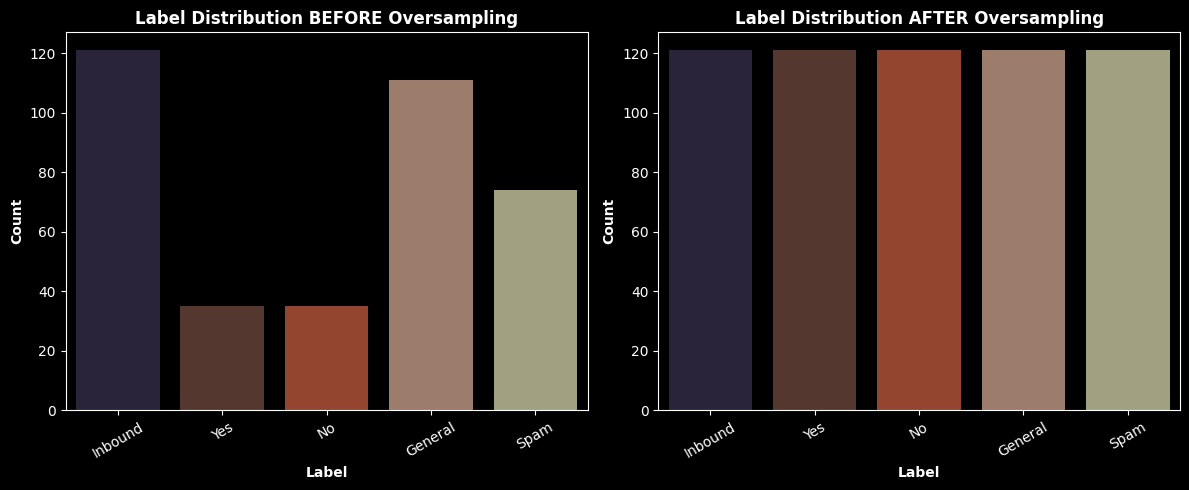

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = [color_inbound, color_yes, color_no, color_general, color_spam]
custom_labels = {0: "Inbound", 1: "Yes", 2: "No", 3: "General", 4: "Spam"}
custom_labels = [custom_labels[i] for i in sorted(y_train.unique())]

# BEFORE Oversampling
sns.countplot(x=y_train, palette=colors, ax=axes[0])
axes[0].set_title("Label Distribution BEFORE Oversampling", fontweight='bold')
axes[0].set_xlabel("Label", fontweight='bold')
axes[0].set_ylabel("Count", fontweight='bold')
axes[0].set_xticklabels(custom_labels, rotation=30)

# AFTER Oversampling
sns.countplot(x=y_train_resampled, palette=colors, ax=axes[1])
axes[1].set_title("Label Distribution AFTER Oversampling", fontweight='bold')
axes[1].set_xlabel("Label", fontweight='bold')
axes[1].set_ylabel("Count", fontweight='bold')
axes[1].set_xticklabels(custom_labels, rotation=30)

plt.tight_layout()
plt.show()


As we can see, the classes are now balanced.  Let's see if this improves the model for the "Yes" and "No" responses.

Next, I'll create the LSTM model with the new hyperparameters.

In [40]:
lstm_model_v2 = create_lstm(
    embedding,
    spatial_dropout=0.5, # Increased dropout from 0.3 to 0.5
    lstm_units=128,
    dropout=0.5, # Increased dropout from 0.3 to 0.5
    recurrent_dropout=0.5,
    dense_units=64,
    learning_rate=0.00001 # Decreased learning rate from 0.0001 to 0.00001
)

lstm_model_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)          │ (None, 714)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 714, 200)       │       899,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 714, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,525 (4.78 MB)

 Trainable params: 353,797 (1.35 MB)

 Non-trainable params: 899,728 (3.43 MB)

Great, let's train the model again.  Note, I'm not going to use early stopping this time, because I want to see if the model can learn the data better.  I decreased the epochs from 50 to 30.

In [41]:
history_v2 = lstm_model_v2.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=30, # Decreased epochs from 50 to 30
    batch_size=32,
    validation_data=(X_test, y_test),
    # callbacks=[early_stopping] # Removed early stopping
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.1994 - loss: 2.6769 - val_accuracy: 0.0842 - val_loss: 1.6457
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 935ms/step - accuracy: 0.2050 - loss: 2.7604 - val_accuracy: 0.1053 - val_loss: 1.6426
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 833ms/step - accuracy: 0.2186 - loss: 2.7499 - val_accuracy: 0.1158 - val_loss: 1.6402
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 876ms/step - accuracy: 0.1871 - loss: 2.6488 - val_accuracy: 0.1579 - val_loss: 1.6383
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1879 - loss: 2.7281 - val_accuracy: 0.1368 - val_loss: 1.6360
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2140 - loss: 2.6009 - val_accuracy: 0.1368 - val_loss: 1.6350
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2166 - loss: 2.5888 - val_accuracy: 0.1684 - val_loss: 1.6336
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2329 - loss: 2.5973 - val_accuracy: 0.1684 - 

Now, let's take a look at the results in a plot.

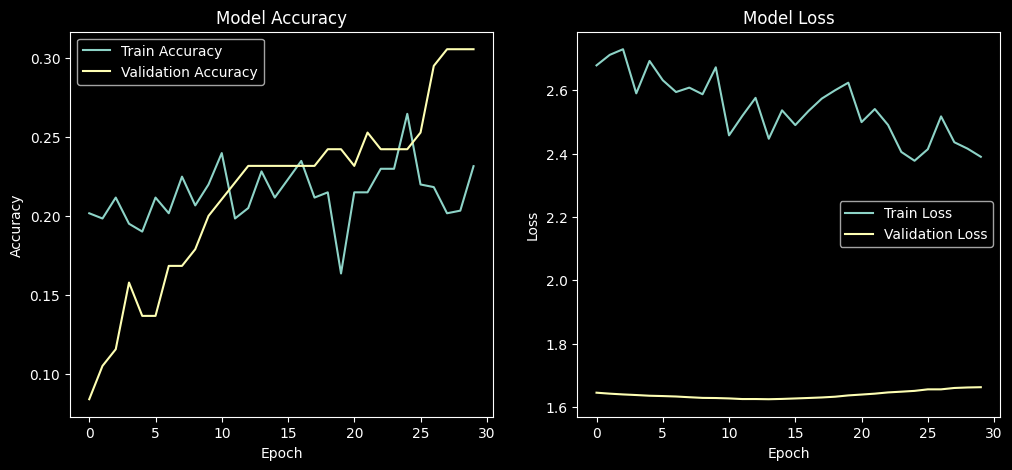

In [42]:
plot_learning_curves(history_v2)

Now, I want to predict the test data and see how well the model did.  I'll take a look at the classification report and confusion matrix.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


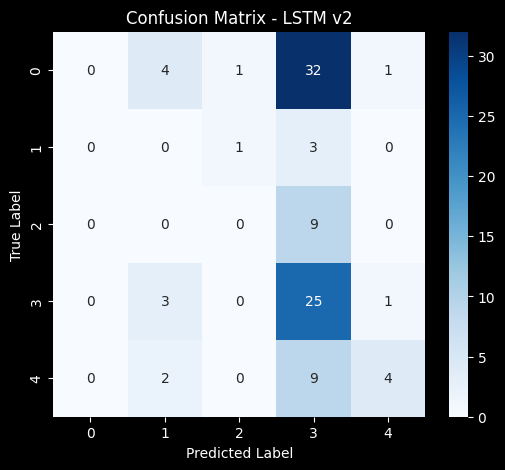

Classification Report:
 {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 38.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}, '3': {'precision': 0.32051282051282054, 'recall': 0.8620689655172413, 'f1-score': 0.4672897196261682, 'support': 29.0}, '4': {'precision': 0.6666666666666666, 'recall': 0.26666666666666666, 'f1-score': 0.38095238095238093, 'support': 15.0}, 'accuracy': 0.30526315789473685, 'macro avg': {'precision': 0.19743589743589746, 'recall': 0.22574712643678158, 'f1-score': 0.16964842011570985, 'support': 95.0}, 'weighted avg': {'precision': 0.20310391363022942, 'recall': 0.30526315789473685, 'f1-score': 0.20279671140467992, 'support': 95.0}}


In [ ]:
y_pred = lstm_model_v2.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM v2")
plt.show()

report = classification_report(y_test, y_pred_classes, output_dict=True)
print("Classification Report:\n", report)


In [45]:
# TODO ADD ANALYSIS OF CLASSIFICATION REPORT AND CONFUSION MATRIX AFTER I'VE ADDED ADDITIONAL DATA TO THE MODEL

### LSTM Model - Version 3 - Class Weights

As we saw in the second model, the "Yes" and "No" responses were STILL not classified well.  This time I'll try to fix that and to try to improve the performance of the LSTM model overall.  I will try to balance the classes and tweak some of the hyperparameters.

<strong>Key Changes in LSTM Version 3</strong>
1. Class weights - instead of using oversampling, I'll try class weights
2. Decrease the Dropout Hyperparameter from 0.5 to 0.4 to reduce overfitting
3. Learning Rate - I will slightly incresae the learning rate from 0.00001 to 0.00005.
4. Reimplement early stopping - I will use early stopping again to prevent overfitting.
5. Increase the number of epochs from 30 to 50 to allow the model to learn the data better.

First off, I'll apply those class weights.

In [46]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

Next, I'll define the model again with the updated hyperparameters.

In [47]:
lstm_model_v3 = create_lstm(
    embedding,
    spatial_dropout=0.4, # Decreased dropout from 0.5 to 0.4
    lstm_units=128,
    dropout=0.4, # Increased dropout from 0.5 to 0.4
    recurrent_dropout=0.5,
    dense_units=64,
    learning_rate=0.00005 # Increased learning rate from 0.00001 to 0.00005
)

lstm_model_v3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)          │ (None, 714)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 714, 200)       │       899,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 714, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,525 (4.78 MB)

 Trainable params: 353,797 (1.35 MB)

 Non-trainable params: 899,728 (3.43 MB)

Now, let's run v3!

In [48]:
history_v3 = lstm_model_v3.fit(
    X_train,
    y_train,
    class_weight=class_weight_dict,
    epochs=50, # Increased epochs from 30 to 50
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping] # Added early stopping
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 990ms/step - accuracy: 0.1697 - loss: 2.4876 - val_accuracy: 0.3684 - val_loss: 1.5835
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1000ms/step - accuracy: 0.2258 - loss: 2.2420 - val_accuracy: 0.3684 - val_loss: 1.5831
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 878ms/step - accuracy: 0.1672 - loss: 2.6626 - val_accuracy: 0.3474 - val_loss: 1.5826
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 958ms/step - accuracy: 0.1826 - loss: 2.6025 - val_accuracy: 0.3474 - val_loss: 1.5822
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 885ms/step - accuracy: 0.1794 - loss: 2.4244 - val_accuracy: 0.3263 - val_loss: 1.5812
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 923ms/step - accuracy: 0.2151 - loss: 2.2958 - val_accuracy: 0.3053 - val_loss: 1.5791
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 878ms/step - accuracy: 0.2198 - loss: 2.1157 - val_accuracy: 0.2947 - val_loss: 1.5754
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2222 - loss: 2.7174 - val_accura

Now let's take a look at v3's results.

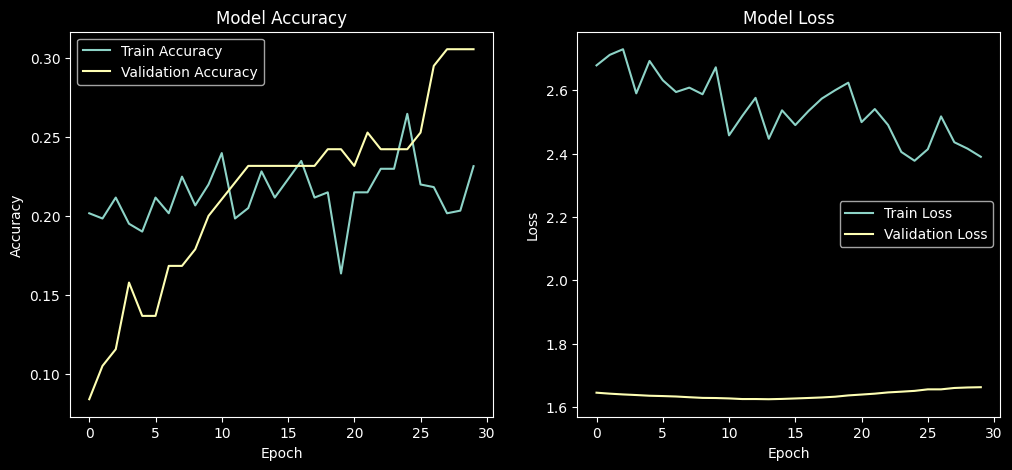

In [49]:
plot_learning_curves(history_v2)

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x2a8159d80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step


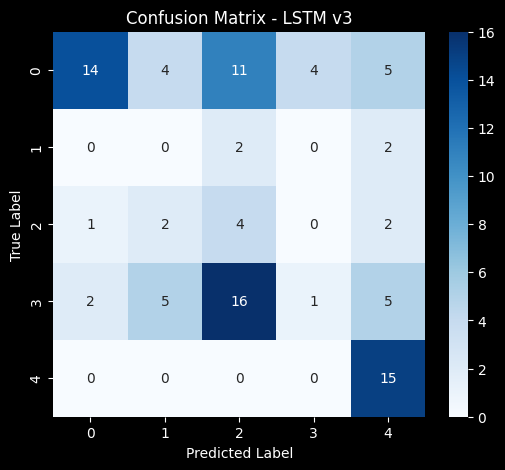

Classification Report:
 {'0': {'precision': 0.8235294117647058, 'recall': 0.3684210526315789, 'f1-score': 0.509090909090909, 'support': 38.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '2': {'precision': 0.12121212121212122, 'recall': 0.4444444444444444, 'f1-score': 0.19047619047619047, 'support': 9.0}, '3': {'precision': 0.2, 'recall': 0.034482758620689655, 'f1-score': 0.058823529411764705, 'support': 29.0}, '4': {'precision': 0.5172413793103449, 'recall': 1.0, 'f1-score': 0.6818181818181818, 'support': 15.0}, 'accuracy': 0.35789473684210527, 'macro avg': {'precision': 0.3323965824574344, 'recall': 0.3694696511393426, 'f1-score': 0.28804176215940924, 'support': 95.0}, 'weighted avg': {'precision': 0.48361734134340095, 'recall': 0.35789473684210527, 'f1-score': 0.3472936351574122, 'support': 95.0}}


In [50]:
y_pred = lstm_model_v3.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM v3")
plt.show()

report = classification_report(y_test, y_pred_classes, output_dict=True)

add_results_to_overall_report(report, "LSTM v3")

# IV. Results & Analysis

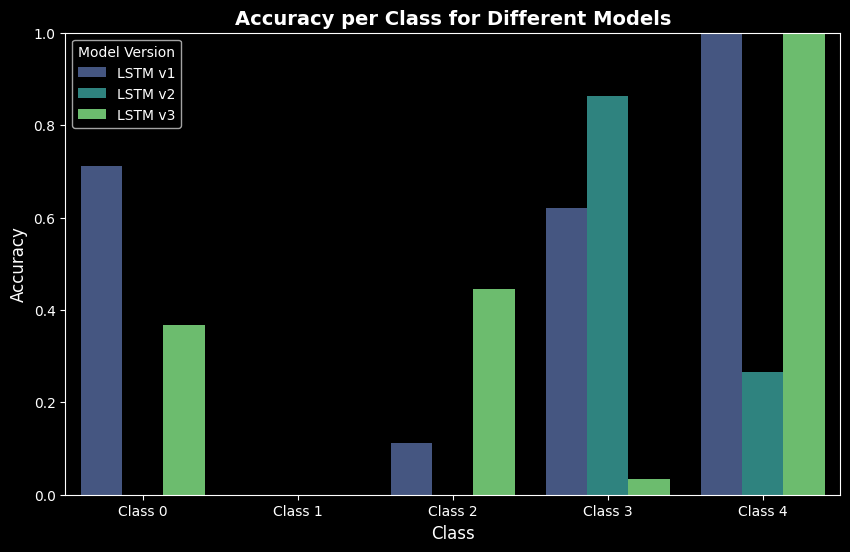

In [51]:
df_results = pd.DataFrame(model_results)

# Reshape Data for Visualization (Convert Wide to Long Format)
df_melted = df_results.melt(id_vars=["Model"], var_name="Class", value_name="Accuracy")

# Plot Accuracy Per Class for Each Model
plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Accuracy", hue="Model", data=df_melted, palette="viridis")

# Labels & Title
plt.title("Accuracy per Class for Different Models", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.legend(title="Model Version")

# Show the plot
plt.show()


# Conclusion

### Things to continue trying:
- Try the Twitter GloVe embeddings
- Try including more features from the dataset.  For example, I could use the email address to see if that has any impact on the classification.

# References

- https://nlp.stanford.edu/projects/glove/
- https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert#2.-Simple-LSTM-Model